In [2]:
from sidechainnet.examples import get_alphabet_protein
import sidechainnet as scn
from sidechainnet.structure import fastbuild
from sidechainnet.utils.minimizer import SCNMinimizer
from sidechainnet.utils.openmm_loss import OpenMMEnergyH
import torch
from sidechainnet.structure.build_info import (_BACKBONE_ATOMS, _SUPPORTED_TERMINAL_ATOMS,
                                               ANGLE_NAME_TO_IDX_MAP, BB_BUILD_INFO,
                                               NUM_COORDS_PER_RES,
                                               NUM_COORDS_PER_RES_W_HYDROGENS,
                                               SC_ANGLES_START_POS, SC_HBUILD_INFO, ATOM_MAP_H)
import copy
torch.set_printoptions(sci_mode=False)
import numpy as np
np.set_printoptions(suppress=True)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.facecolor'] = 'white'


# Study differences between raw and rebuilt alphabet protein

In [2]:
p = get_alphabet_protein()
p
# p.to_pdb("alphabet1006.pdb")

SCNProtein(ALFA_1_A, len=21, missing=0, split='train')

In [3]:
# p = scn.load_pdb("/home/jok120/sidechainnet/sidechainnet/examples/alphabet_protein.pdb")
p.to_3Dmol()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [4]:
p.torch()
p.fastbuild(add_hydrogens=True, inplace=True)
p.to_3Dmol()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [8]:
p.get_energy()

Quantity(value=-1789.5192230867842, unit=kilojoule/mole)

In [9]:
p.get_energy_loss()

tensor(-1789.519, dtype=torch.float64, grad_fn=<OpenMMEnergyHBackward>)

In [10]:
minimizer = SCNMinimizer()
minimizer.minimize_scnprotein(p, epochs=200)

Starting loss = -1789.52
Epoch 0:	-1828.16
Epoch 0: Loss has been updated.  tensor(-1828.160, dtype=torch.float64, grad_fn=<OpenMMEnergyHBackward>)
Epoch 1:	-1885.63
Epoch 1: Loss has been updated.  tensor(-1885.634, dtype=torch.float64, grad_fn=<OpenMMEnergyHBackward>)
Epoch 2:	-1898.23
Epoch 3:	-1905.84
Epoch 3: Loss has been updated.  tensor(-1905.842, dtype=torch.float64, grad_fn=<OpenMMEnergyHBackward>)
Epoch 4:	-1911.55
Epoch 5:	-1913.76
Epoch 6:	-1920.32
Epoch 7:	-1921.58
Epoch 7: Loss has been updated.  tensor(-1921.576, dtype=torch.float64, grad_fn=<OpenMMEnergyHBackward>)
Epoch 8:	-1927.65
Epoch 9:	-1927.93
Epoch 10:	-1933.68
Epoch 11:	-1933.72
Epoch 12:	-1939.83
Epoch 12: Loss has been updated.  tensor(-1939.831, dtype=torch.float64, grad_fn=<OpenMMEnergyHBackward>)
Epoch 13:	-1939.47
Epoch 14:	-1945.44
Epoch 15:	-1944.97
Epoch 16:	-1950.97
Epoch 17:	-1950.00
Epoch 18:	-1955.75
Epoch 18: Loss has been updated.  tensor(-1955.752, dtype=torch.float64, grad_fn=<OpenMMEnergyHBac

KeyboardInterrupt: 

In [9]:
p.to_pdb("minimized_alphabet.pdb")

In [10]:
!pwd

/home/jok120/sidechainnet/sidechainnet/research/analysis


In [ ]:
p.seq.find('V')

In [ ]:
p.coords[18]

In [ ]:
p.get_atom_names(zip_coords=True)

In [ ]:
print(p.to_pdbstr())

In [ ]:
binf_allatom = fastbuild.SC_ALL_ATOM_BUILD_PARAMS
binf_heavy = fastbuild.SC_HEAVY_ATOM_BUILD_PARAMS

In [ ]:
binf_allatom.keys()

In [ ]:
binf_heavy.keys()

In [ ]:
binf_allatom['CA'].keys(), binf_heavy['CA'].keys()

In [ ]:
binf_allatom['CA']['bond_lengths'].shape, binf_heavy['CA']['bond_lengths'].shape

In [ ]:
binf_heavy_copy = copy.deepcopy(binf_heavy)

In [ ]:
binf_heavy['CA']['bond_lengths'][2]

In [ ]:
binf_allatom['CA']['bond_lengths'][2]

In [ ]:
fastbuild.AA[17]

In [ ]:
SC_HBUILD_INFO['ASP']

In [ ]:
def update_buildparams_for_heavy_atoms_with_full_buildparams(heavy_bp, full_bp):
    nres = len(fastbuild.AA)
    ncoords = NUM_COORDS_PER_RES_W_HYDROGENS - (
        len(_SUPPORTED_TERMINAL_ATOMS) + len(set(_BACKBONE_ATOMS + ['H']))
    )  # TODO Automate this by pulling out the max list of atom names in build info
    assert ncoords == 19
    for a in range(nres):
        A = fastbuild.AA[a]
        if len(A) == 2:
            # If this residue is an N or C terminal residue, the atoms built off of the
            # alpha Carbon are identical to the non-terminal residue version
            A = A[1]
        a3 = fastbuild.AA1to3[A]
        info = SC_HBUILD_INFO[a3]
        i = 0
        print(len(info['torsion-vals']), ":")
        for i in range(ncoords):
            an = info['torsion-names'][i].split('-')[-1].strip() if i < len(info['torsion-vals']) else None
            if i >= len(info['torsion-vals']) or an.startswith("H"):
                break
       
        heavy_bp['CA']['bond_lengths'][a, :i] = full_bp['CA']['bond_lengths'][a, :i]
        heavy_bp['CA']['cthetas'][a, :i] = full_bp['CA']['cthetas'][a, :i]
        heavy_bp['CA']['sthetas'][a, :i] = full_bp['CA']['sthetas'][a, :i]
        heavy_bp['CA']['cchis'][a, :i] = full_bp['CA']['cchis'][a, :i]
        heavy_bp['CA']['schis'][a, :i] = full_bp['CA']['schis'][a, :i]
        heavy_bp['CA']['types'][a, :i] = full_bp['CA']['types'][a, :i]
        heavy_bp['CA']['offsets'][a, :i] = full_bp['CA']['offsets'][a, :i]
        heavy_bp['CA']['sources'][a, :i] = full_bp['CA']['sources'][a, :i]
    
    return heavy_bp



In [ ]:
binf_heavy_updated = update_buildparams_for_heavy_atoms_with_full_buildparams(binf_heavy, binf_allatom)

In [ ]:
idx = 17

In [ ]:
#Original heavy
binf_heavy_copy['CA']['bond_lengths'][idx]

In [ ]:
# Original all atom
binf_allatom['CA']['bond_lengths'][idx]

In [ ]:
# Updated heavy using all atom params
binf_heavy['CA']['bond_lengths'][idx]

In [ ]:
# Updated heavy using all atom params
binf_heavy_updated['CA']['bond_lengths'][idx]

In [ ]:
binf_allatom['CA']['names'][idx]

In [ ]:
fastbuild.get_all_atom_build_params()['CA']['bond_lengths'][idx]

# Compare Minimized Build Dict to Original Build Dict

In [3]:
min_bparams = fastbuild.SC_ALL_ATOM_BUILD_PARAMS
raw_bparams = fastbuild.get_all_atom_build_params()
for root_atom in ['N', 'CA', 'C']:
    raw_bparams[root_atom]['thetas'] = torch.atan2(raw_bparams[root_atom]['sthetas'],
                                        raw_bparams[root_atom]['cthetas'])
    raw_bparams[root_atom]['chis'] = torch.atan2(raw_bparams[root_atom]['schis'],
                                                   raw_bparams[root_atom]['cchis'])


In [4]:
raw_bparams.keys(), min_bparams['CA'].keys()

(dict_keys(['N', 'CA', 'C']),
 dict_keys(['bond_lengths', 'cthetas', 'sthetas', 'cchis', 'schis', 'types', 'offsets', 'sources', 'names', 'thetas', 'chis']))

In [5]:
raw_bparams['CA']['chis'], min_bparams['CA']['chis']

(tensor([[     0.000,      0.000,     -0.000,  ...,      0.000,      0.000,
               0.000],
         [     0.000,      0.000,      0.000,  ...,      0.000,      0.000,
               0.000],
         [     0.000,      0.000,      0.000,  ...,      0.000,      0.000,
               0.000],
         ...,
         [     0.000,      0.000,      0.000,  ...,      0.000,      0.000,
               0.000],
         [     0.000,      0.000,      0.000,  ...,      3.142,      3.142,
               3.142],
         [     0.000,      0.000,      0.000,  ...,      0.000,      0.000,
               0.000]]),
 tensor([[0.000, 0.000, 1.031,  ..., 0.000, 0.000, 0.000],
         [0.000, 0.000, 0.000,  ..., 0.000, 0.000, 0.000],
         [0.000, 0.000, 0.000,  ..., 0.000, 0.000, 0.000],
         ...,
         [0.000, 0.000, 0.000,  ..., 0.000, 0.000, 0.000],
         [0.000, 0.000, 0.000,  ..., 3.142, 3.142, 3.142],
         [0.000, 0.000, 0.000,  ..., 0.000, 0.000, 0.000]], requires_grad=True))

In [8]:
from sidechainnet.structure.fastbuild import NUM2AA, AA1to3

SC_HBUILD_INFO['HIS']['atom-names']
def ispad(anlist):
    newlist = ['P'] * 19
    for i in range(len(anlist)):
        newlist[i] = anlist[i]
    return newlist

def makelabels():
    padlabels = []
    for resnum in range(20):
        padlabels.append(ispad(SC_HBUILD_INFO[AA1to3[NUM2AA[resnum]]]['atom-names']))
    return padlabels

# ispad(SC_HBUILD_INFO[AA1to3[NUM2AA[6]]]['atom-names'])
padlabels = makelabels()

bond_lengths torch.Size([60, 19])


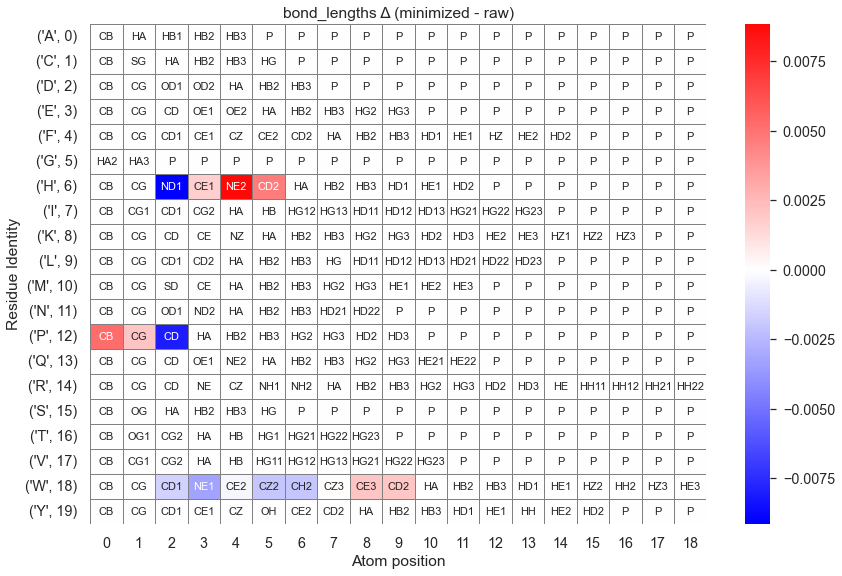

cthetas torch.Size([60, 19])


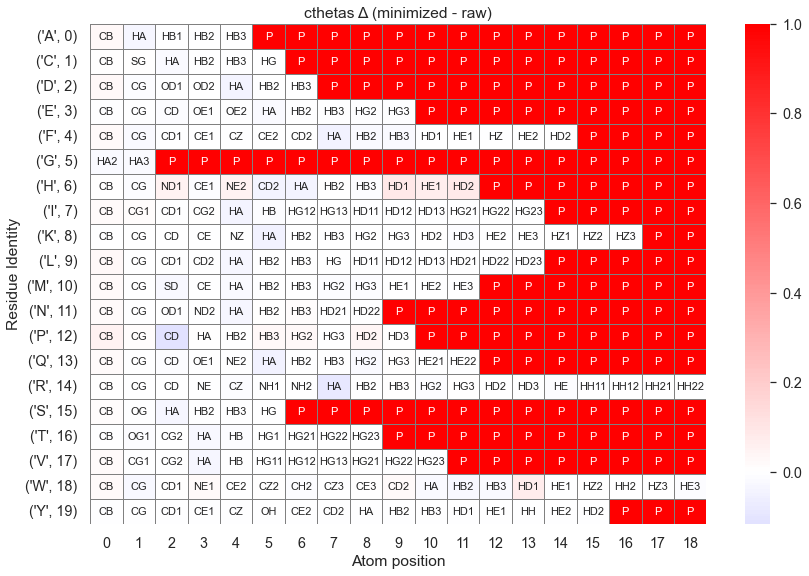

sthetas torch.Size([60, 19])


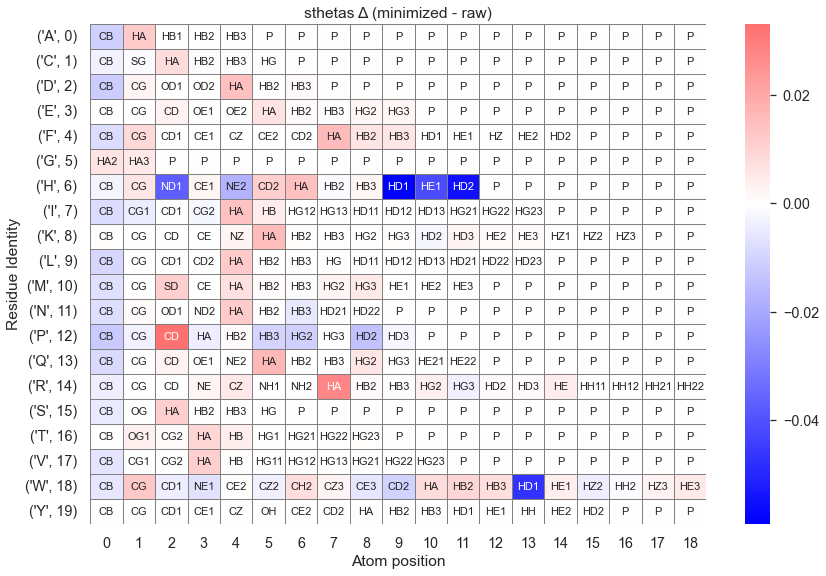

cchis torch.Size([60, 19])


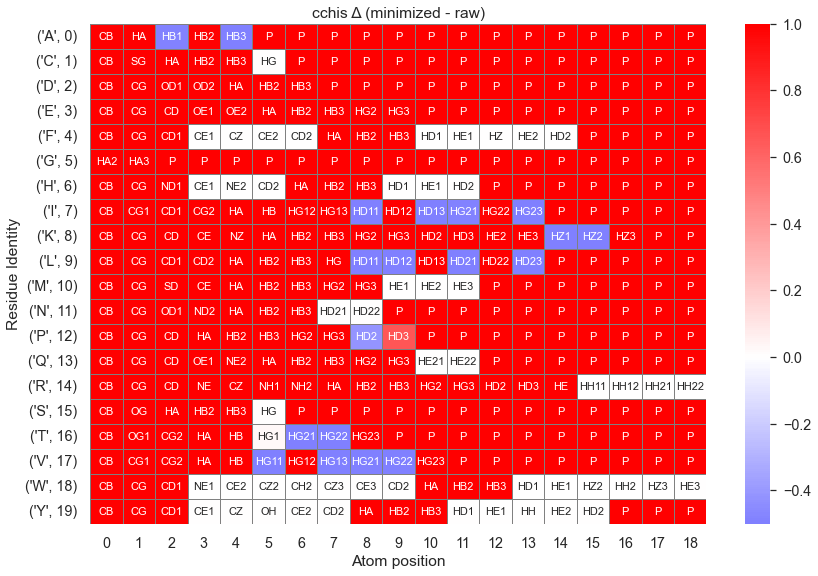

schis torch.Size([60, 19])


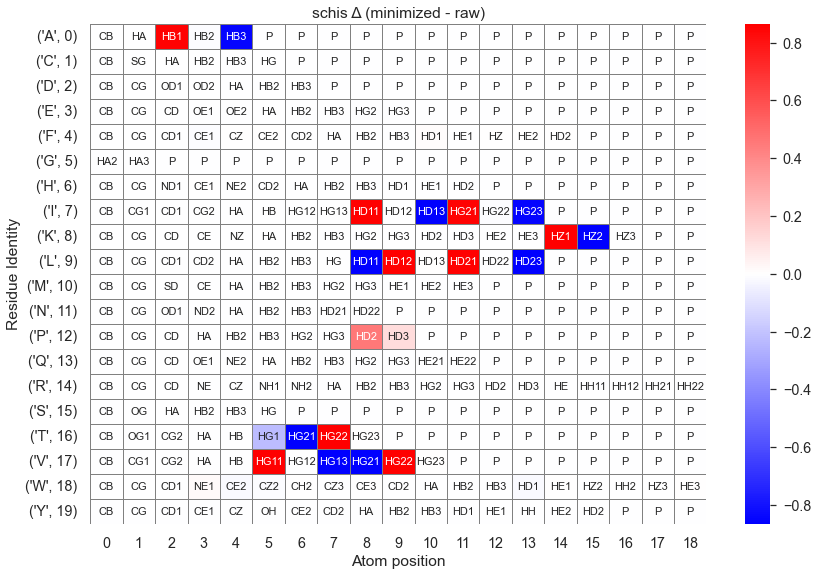

types torch.Size([60, 19])
No difference.
offsets torch.Size([60, 19])
No difference.
sources torch.Size([60, 19])
No difference.
thetas torch.Size([60, 19])


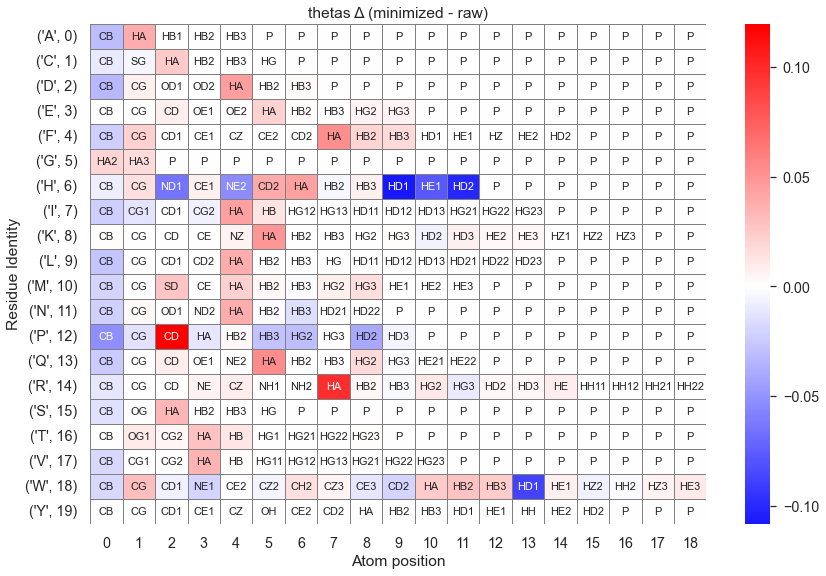

chis torch.Size([60, 19])


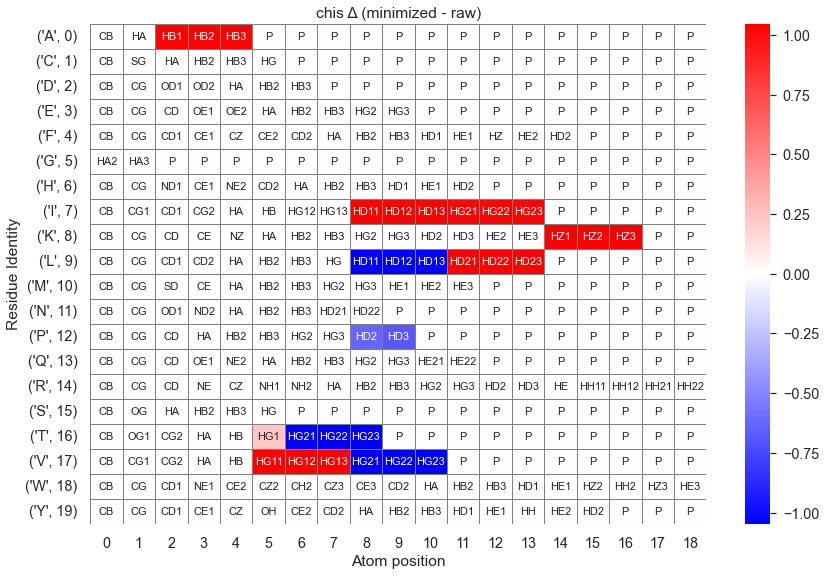

In [31]:
%matplotlib inline
from sidechainnet.structure.fastbuild import AA, AA1to3


for ((bparam_name, raw_bp_tensor), (bparam_name, min_bp_tensor)
    ) in zip(raw_bparams['CA'].items(), min_bparams['CA'].items()):
    if bparam_name == "names":
        continue
    diff = min_bp_tensor - raw_bp_tensor
    print(bparam_name, diff.shape)
    if diff.sum() == 0:
        print("No difference.")
        continue
    with plt.style.context('seaborn'):
        sns.set(font_scale=1.3)

        plt.figure(figsize = (6*2.3,4*2.3))
        g = sns.heatmap(diff[:20].detach().numpy(),
            yticklabels=list(zip(AA[:20], range(0,20))), linewidths=.5,
            linecolor='grey', center=0, cmap='bwr', annot=padlabels, fmt='', annot_kws={"fontsize":11},
            )
        # g.fig.set_size_inches(3*2, 4*2)
        plt.ylabel("Residue Identity")
        plt.xlabel("Atom position")
        plt.gca().set_facecolor("white")
        plt.title(bparam_name + " Δ (minimized - raw)")
        plt.yticks(rotation=0)
        
        plt.savefig(f"plots/minimized_raw_{bparam_name}.png", dpi=200)
        plt.show()


bond_lengths torch.Size([60, 19])
thetas torch.Size([60, 19])
chis torch.Size([60, 19])


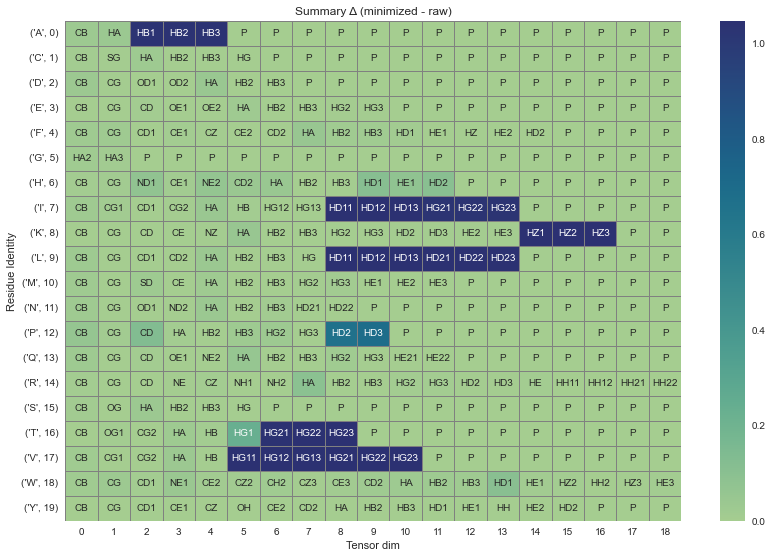

In [23]:
%matplotlib inline
from sidechainnet.structure.fastbuild import AA, AA1to3

total_diff = diff * 0.
for ((bparam_name, raw_bp_tensor), (bparam_name, min_bp_tensor)
    ) in zip(raw_bparams['CA'].items(), min_bparams['CA'].items()):
    if bparam_name not in ["thetas","chis","bond_lengths"]:
        continue
    diff = min_bp_tensor - raw_bp_tensor
    print(bparam_name, diff.shape)
    if diff.sum() == 0:
        continue
    total_diff += diff.abs()
with plt.style.context('seaborn'):
    plt.figure(figsize = (6*2.3,4*2.3))
    sns.heatmap(total_diff[:20].detach().numpy(),
        yticklabels=list(zip(AA[:20], range(0,20))), linewidths=.5,
        linecolor='grey', center=None, cmap='crest', annot=padlabels, fmt=''
        )
    plt.ylabel("Residue Identity")
    plt.xlabel("Tensor dim")
    plt.gca().set_facecolor("white")
    plt.title("Summary Δ (minimized - raw)")
    plt.yticks(rotation=0)
    plt.show()


In [17]:
p = get_alphabet_protein()
p.mask = "-" + p.mask[1:]
p.trim_edges()
print(p.seq)
p.torch()
p.fastbuild(add_hydrogens=True, inplace=True)
efunc = OpenMMEnergyH()
loss = efunc.apply(p, p.hcoords)
loss


ACDEFGHIKLMNPQRSTVWY


tensor(-1828.939, dtype=torch.float64, grad_fn=<OpenMMEnergyHBackward>)

In [18]:
from sidechainnet.structure.fastbuild import AA2NUM, AA3to1


raw_bparams['CA']['bond_lengths'][6], min_bparams['CA']['bond_lengths'][6]

(tensor([1.526, 1.504, 1.385, 1.343, 1.335, 1.394, 1.090, 1.090, 1.090, 1.010,
         1.080, 1.080, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000]),
 tensor([1.526, 1.504, 1.376, 1.345, 1.344, 1.399, 1.090, 1.090, 1.090, 1.010,
         1.080, 1.080, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000],
        grad_fn=<SelectBackward0>))

In [19]:
raw_bparams['CA']['sources'][6], min_bparams['CA']['sources'][6]

(tensor([-1,  0,  1,  2,  3,  4, -1,  0,  0,  2,  3,  5,  0,  0,  0,  0,  0,  0,
          0]),
 tensor([-1,  0,  1,  2,  3,  4, -1,  0,  0,  2,  3,  5,  0,  0,  0,  0,  0,  0,
          0]))

In [20]:
from sidechainnet.structure.fastbuild import get_all_atom_build_params


p = get_alphabet_protein()
# p.mask = "-" + p.mask[1:]
# p.trim_edges()
p.torch()
p.fastbuild(add_hydrogens=True, inplace=True, build_params=get_all_atom_build_params())
print("Energy before:", end=" ")
print(p.get_energy_loss())


p = get_alphabet_protein()
# p.mask = "-" + p.mask[1:]
# p.trim_edges()
p.torch()
p.fastbuild(add_hydrogens=True, inplace=True, build_params=None)
# efunc = OpenMMEnergyH()
# loss = efunc.apply(p, p.hcoords)
print("Energy after:", end=" ")
print(p.get_energy_loss())

Energy before: tensor(-1071.833, dtype=torch.float64)
Energy after: tensor(-1789.519, dtype=torch.float64, grad_fn=<OpenMMEnergyHBackward>)


In [21]:
from sidechainnet.structure.fastbuild import get_all_atom_build_params
data = {"before":{}, "after":{}}

print("Comparing protein energy (without nonbonded forces) before/after minimization"
      " of build parameters.\n")

p = get_alphabet_protein()
p.torch()
p.fastbuild(add_hydrogens=True, inplace=True, build_params=get_all_atom_build_params())
print("Energy before:")
p.openmm_initialized = False
data["before"]["nonbonded=False"] = p.get_energy_loss(nonbonded_interactions=False).item()

p = get_alphabet_protein()
p.torch()
p.fastbuild(add_hydrogens=True, inplace=True, build_params=None)
print("Energy after:")
p.openmm_initialized = False
data["after"]["nonbonded=False"] = p.get_energy_loss(nonbonded_interactions=False).item()

print("\n\nComparing protein energy (WITH nonbonded forces) before/after minimization "
      "of build parameters.\n")

p = get_alphabet_protein()
p.torch()
p.fastbuild(add_hydrogens=True, inplace=True, build_params=get_all_atom_build_params())
print("Energy before:")
data["before"]["nonbonded=True"] = p.get_energy_loss(nonbonded_interactions=True).item()

p = get_alphabet_protein()
p.torch()
p.fastbuild(add_hydrogens=True, inplace=True, build_params=None)
print("Energy after:")
data["after"]["nonbonded=True"] = p.get_energy_loss(nonbonded_interactions=True).item()

print(data)

Comparing protein energy (without nonbonded forces) before/after minimization of build parameters.

Energy before:
Removing <openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x7f405e5fed50> >.
Energy after:
Removing <openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x7f405e43d930> >.


Comparing protein energy (WITH nonbonded forces) before/after minimization of build parameters.

Energy before:
Energy after:
{'before': {'nonbonded=False': 31.133664474643638, 'nonbonded=True': -1071.8334637515143}, 'after': {'nonbonded=False': -326.31879714852096, 'nonbonded=True': -1789.5192230867842}}


In [1]:
import pandas as pd
with plt.style.context('default'):
    pd.DataFrame(data).plot(kind='bar', rot=0)
    plt.title("Alphabet Protein Energy Before/After Minimization")
    ax = plt.gca()
    ax.set_ylim(ax.get_ylim()[::-1])
# plt.savefig("energy_before_after_minimization.png")

NameError: name 'plt' is not defined

In [46]:
p = get_alphabet_protein()
p.torch()
p.fastbuild(add_hydrogens=True, inplace=True, build_params=get_all_atom_build_params())
p.to_pdb("default.pdb")

p = get_alphabet_protein()
p.torch()
p.fastbuild(add_hydrogens=True, inplace=True, build_params=None)
p.to_pdb("minparams.pdb")